In [1]:
## ---------------------------------------------------------------------
## set up configs for huggingface hub and OS paths on HPC cluster -- make sure config.ini is correct
## ---------------------------------------------------------------------
import configparser
def auth_token():

    config = configparser.ConfigParser()
    config.read("config.ini")
    return config["hugging_face"]["token"]

def scratch_path():
    config = configparser.ConfigParser()
    config.read("config.ini")
    return "/scratch/" + config["user"]["username"] + "/"

import os
if os.path.isdir(scratch_path()):
    os.environ['TRANSFORMERS_CACHE'] = scratch_path() + '.cache/huggingface'
    os.environ['HF_DATASETS_CACHE'] = scratch_path() + '.cache/huggingface/datasets'
print(os.getenv('TRANSFORMERS_CACHE'))
print(os.getenv('HF_DATASETS_CACHE'))

## ---------------------------------------------------------------------
## Load libraries
## ---------------------------------------------------------------------

import numpy as np
import pandas as pd

import torch
import transformers
from transformers import AutoTokenizer, AutoModel, LlamaForCausalLM, LlamaTokenizer

import torch.nn.functional as F

from easyeditor import LoRAHyperParams
from easyeditor.util import nethook
from easyeditor.custom import * # gets my custom functions

from entailma import *
from tqdm.notebook import tqdm

from sentence_transformers.cross_encoder import CrossEncoder
## ---------------------------------------------------------------------
## Ensure GPU is available -- device should == 'cuda'
## ---------------------------------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device = ", device)

/scratch/dmpowell/.cache/huggingface
/scratch/dmpowell/.cache/huggingface/datasets


/home/dmpowell/.conda/envs/llama3.1/lib/python3.9/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


device =  cuda


In [2]:
## ---------------------------------------------------------------------
## load llama-2 and set up a pipeline
## ---------------------------------------------------------------------

# MODEL_NAME = "meta-llama/Llama-2-7b-hf" 

# tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# pipeline = transformers.pipeline(
#     "text-generation",
#     model = MODEL_NAME,
#     torch_dtype=torch.float16,
#     device_map="auto",
#     use_auth_token = auth_token()
# )

In [3]:
df = pd.read_csv("data/obqa/test.tsv", sep='\t')
df2 = df.copy().tail(10) # smaller df for testing

## Editing stuff

## premise generation

1. generate premises for correct answer
2. generate premises for each of incorrect answers

## question answering

1. answer questions (get answer probabilities)
2. edit + answer questions (get answer probabilities)
3. edit for each incorrect + answer questions (get answer probabilties)

## generating edits

Probably need some logic to decide what is "prompt" and what is "target" for editing -- i.e. what part of premises get masked. Or maybe could just use something arbitrary like 25% of tokens or something? The problem would be if your edits just reinforce the tokens in the answer as more probable (or possibly similar tokens). That would leave a somewhat deflationary explanation for why it might benefit performance.

In [2]:
hparams = LoRAHyperParams.from_hparams('hparams/LoRA/llama-7b-canonical.yaml')
edited_model = EditedModel(hparams, auth_token()) 

2024-08-22 15:49:20,267 - easyeditor.editors.editor - INFO - Instantiating model
08/22/2024 15:49:20 - INFO - easyeditor.editors.editor -   Instantiating model


08/22/2024 15:49:23 - INFO - accelerate.utils.modeling -   We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-22 15:49:50,801 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
08/22/2024 15:49:50 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...


In [9]:
edited_model.generate_text('', max_new_tokens = 50)


['\\title{Spectral properties of the 2D Dirac equation with anisotropic mass and magnetic field}\n\n\\begin{abstract}\nIn this paper, we study the spectral properties of the Dirac equation in the presence']

In [4]:
# df = pd.read_csv("data/obqa/test.tsv", sep='\t')
# df2 = df.copy().tail(100) # smaller df for testing

# df2.columns = df2.columns.str.replace(' ', '_')
# df2.columns = df2.columns.str.lower()

# df2 = (
#     df2
#     .assign(foils = lambda d: d.apply(lambda x: [i for i in ["A","B","C","D"] if i != x["answer_key"]], 1))
#     .assign(
#         F1 = lambda d: d.apply(lambda x: x.foils[0], 1),
#         F2 = lambda d: d.apply(lambda x: x.foils[1], 1),
#         F3 = lambda d: d.apply(lambda x: x.foils[2], 1)
#         ).
#     assign(
#         # premises_corr = lambda d: d.apply(lambda row: generate_premises(row['complete_question'], row['answer_key'], edited_model.model, edited_model.tok), 1)#,
#         premises_F1 = lambda d: d.apply(lambda row: generate_premises(row['complete_question'], row['F1'], edited_model.model, edited_model.tok), 1)
#         # premises_F2 = lambda d: d.apply(lambda row: generate_premises(row['complete_question'], row['F2'], edited_model.model, edited_model.tok), 1), # being stingy with time
#         # premises_F3 = lambda d: d.apply(lambda row: generate_premises(row['complete_question'], row['F3'], edited_model.model, edited_model.tok), 1),
#     )
# )
from ast import literal_eval

df_all = pd.read_csv("test-tail100-premises-bestof32-copy.tsv", sep = '\t', converters={'foils':literal_eval, 'corr_premises':literal_eval, 'F1_premises':literal_eval, 'edited_corr_premises': literal_eval})
df = df_all.loc[lambda x: x.premises_valid == 'Yes'].loc[lambda x: x.corr_score > 1.5].loc[lambda x: x.F1_score > 1.5]

df.head()

,Unnamed: 0,id,question_stem,choices,complete_question,answer_key,foils,F1,F2,F3,corr_premises,F1_premises,corr_score,F1_score,premises_valid,edited_corr_premise
0,400,936,Animals died after the removal of a,(A) bush (B) street (C) house (D) city,Animals died after the removal of a (A) bush (...,A,"[B, C, D]",B,C,D,[The removal of a bush can cause animals to di...,[Streets are artificial environments that can ...,3.599609,8.203125,Yes,['The removal of a house can cause animals to ...
1,401,8-478,"If I want to go running at night, what can I u...",(A) A black shirt (B) Kitchen foil (C) Sunglas...,"If I want to go running at night, what can I u...",B,"[A, C, D]",A,C,D,"[Kitchen foil reflects light., It can be used ...",[A reflector can be used to increase visibilit...,10.085938,2.796875,Yes,"['Sunglasses reflects light.', 'It can be used..."
10,410,7-599,What material has already broken down?,(A) wood (B) glass (C) boulders (D) sand,What material has already broken down? (A) woo...,D,"[A, B, C]",A,B,C,[Sand is a sedimentary rock that has already b...,[Wood is a biological material that has alread...,6.546875,19.250000,Yes,['Glass is a sedimentary rock that has already...
11,411,Aug-92,Which beverage would dissolve solids the best?,(A) A glass of ice-cold water (B) A boiling ho...,Which beverage would dissolve solids the best?...,B,"[A, C, D]",A,C,D,"[Boiling water dissolves solids the best., Boi...",[Ice-cold water has the lowest temperature and...,2.730469,6.527344,Yes,['A cup of warm milk dissolves solids the best...
12,412,354,Which animal has live births?,(A) poodle (B) hummingbird (C) crocodile (D) t...,Which animal has live births? (A) poodle (B) h...,A,"[B, C, D]",B,C,D,[Poodles are mammals and give birth to live yo...,"[Hummingbirds are live-birth animals., They la...",13.703125,4.351562,Yes,['Crocodiles are mammals and give birth to liv...


In [5]:

def split_sentence(x):
    l = x.split(" ")
    out1 = l[:len(l)//2]
    out2 = l[len(l)//2:]
    out2[0] = " " + out2[0]

    return(" ".join(out1), " ".join(out2))


import re
def answer_choice_list(choices):
    options = re.split(r'\s*\(\w\)\s*', choices)
    return( [option.strip() for option in options if option] )



def mc_cloze_logprobs(question, ans_text, model):
    choices = answer_choice_list(ans_text)
    tok = model.tok
    model = model
    prompt = f"{question}? Answer:"
    
    if type(tok) == transformers.models.llama.tokenization_llama.LlamaTokenizer:
        padded_choices = choices
        prompt = prompt + " " if prompt[-1]!= " " else prompt
    else:
        padded_choices = [pad_token(c) for c in choices] # pad all the 
    
    prompts = [prompt + c for c in choices]
    # print(prompts)
    logits = torch.tensor([model.completion_logprob(x[0], x[1]) for x in zip(prompts, choices)])
    
    return(F.log_softmax(logits, -1))


# def split_sentence_at_ans(x, ans):
#     xlow = x.lower()
#     anslow = ans.lower()
#     if ans in xlow:
#         ans_ind = xlow.index(anslow) + len(ans)
#     else:
#         ans_ind = 0
#     return [x[:ans_ind].strip(), x[ans_ind:].strip()]



    # if ans.lower() in xlow:
    #     z = xlow.split(ans.lower())
    #     z[1] = ans + z[1]

    # return(z)

    # l = x.split()

    # ans_ind = l_lower.index(ans.lower()) if ans in l_lower else -1

    # out1 = l[:ans_ind+1]
    # out2 = l[ans_ind+1:]
    # out2[0] = " " + out2[0]

    # return(" ".join(out1).strip(), " ".join(out2).strip())


# split_sentence_at_ans('hello world how are you?', 'gurl')

# choices = answer_choice_list(q.choices)
# ans_ind = ['A','B','C','D'].index(q.answer_key)

# ans =  choices[ans_ind]

# split_sentence_at_ans('hello world How are You?', 'clear')

# mc_cloze_logprobs(complete_question, '(A) belt buckle (B) table (C) paper plate (D) ballerina', edited_model)

NameError: name 'df' is not defined

In [6]:

smodel = CrossEncoder("cross-encoder/stsb-distilroberta-base")


/home/dmpowell/.conda/envs/llama3.1/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
08/22/2024 09:37:51 - INFO - sentence_transformers.cross_encoder.CrossEncoder -   Use pytorch device: cuda


In [7]:
def score_similarity(x1, x2):
    sentence_combinations = [x1, x2]
    score = smodel.predict(sentence_combinations, show_progress_bar = False)
    
    return score


def find_all(a_str, sub):
    start = 0
    while True:
        start = a_str.find(sub, start)
        if start == -1: return
        yield start
        start += len(sub) # use start += 1 to find overlapping matches



def split_sentence_at_ans(x, ans):
    breaks = [0] + list(find_all(x, ' '))
    xlist = []
    for b in breaks:
        xlist.append(x[b:].strip())
    
    scores = [score_similarity(x, ans) for x in xlist]
    
    good_ind = -1
    for i in range(len(scores)):
        if scores[i] < .1:
            good_ind = i
            break

    safe_break = breaks[good_ind]
    return(x[:safe_break], x[safe_break:])
    

# find_split_point('Poodles are mammals and give birth to live young.', 'poodle')

In [8]:
i = 4

df.iloc[i].corr_premises, df.iloc[i].complete_question

(['Poodles are mammals and give birth to live young.',
  'Crocodiles and trout are reptiles and lay eggs.'],
 'Which animal has live births? (A) poodle (B) hummingbird (C) crocodile (D) trout')

In [9]:
# for F1
keep = []
for q in df.itertuples():
    keep.append(all([len(x) > 0 for x in q.F1_premises]))

df = df[keep]

In [85]:
# rewrite = {
#     'prompts': [f'Sweat helps animals regulate their body temperature in'],
#     'target_new': [' cold environments.'], 
#     # 'target_true': [' hot and humid environments.'], 
#     'subject': ['Sweat']
# }

raw_answers_mc = []
edited_answers_mc = []
raw_answers_cloze = []
edited_answers_cloze = []

for e in tqdm(df.itertuples(), total = len(df)):
    
    raw_answers_mc.append(mc_answer_logprobs(e.complete_question, edited_model))
    raw_answers_cloze.append(mc_cloze_logprobs(e.complete_question, e.choices, edited_model))
    
    choices = answer_choice_list(e.choices)
    ans_ind = ['A','B','C','D'].index(e.answer_key)

    ans = choices[ans_ind]

    rewrite = {
        'prompts': [split_sentence_at_ans(x, ans)[0] for x in e.corr_premises],  #  
        'target_new': [split_sentence_at_ans(x, ans)[1] for x in e.corr_premises]
        }
    
    edited_model.edit(rewrite)
    edited_answers_mc.append(mc_answer_logprobs(e.complete_question, edited_model))
    edited_answers_cloze.append(mc_cloze_logprobs(e.complete_question, e.choices, edited_model))
    edited_model.restore()

df["edited_answer_mc"] = [a.cpu().tolist() for a in edited_answers_mc]
df["raw_answer_mc"] = [a.cpu().tolist() for a in raw_answers_mc]
df["edited_answer_cloze"] = [a.cpu().tolist() for a in edited_answers_cloze]
df["raw_answer_cloze"] = [a.cpu().tolist() for a in raw_answers_cloze]

# df["edited_answer_mc"] = edited_answers_mc
# df["raw_answer_mc"] = raw_answers_mc
# df["edited_answer_cloze"] = edited_answers_cloze
# df["raw_answer_cloze"] = raw_answers_cloze


  0%|          | 0/57 [00:00<?, ?it/s]

In [86]:
x = df.assign(
    raw_ans_prob_mc = lambda d: d.apply(lambda x: x.raw_answer_mc[['A','B','C','D'].index(x.answer_key)], 1),
    edited_ans_prob_mc = lambda d: d.apply(lambda x: x.edited_answer_mc[['A','B','C','D'].index(x.answer_key)], 1),
    raw_ans_prob_cloze = lambda d: d.apply(lambda x: x.raw_answer_cloze[['A','B','C','D'].index(x.answer_key)], 1),
    edited_ans_prob_cloze = lambda d: d.apply(lambda x: x.edited_answer_cloze[['A','B','C','D'].index(x.answer_key)], 1),
    raw_answer_mc_choice = lambda d: d.apply(lambda x: ['A','B','C','D'][x.raw_answer_mc.index(max(x.raw_answer_mc))], 1),
    edited_answer_mc_choice = lambda d: d.apply(lambda x: ['A','B','C','D'][x.edited_answer_mc.index(max(x.edited_answer_mc))], 1),
    raw_answer_cloze_choice = lambda d: d.apply(lambda x: ['A','B','C','D'][x.raw_answer_cloze.index(max(x.raw_answer_cloze))], 1),
    edited_answer_cloze_choice = lambda d: d.apply(lambda x: ['A','B','C','D'][x.edited_answer_cloze.index(max(x.edited_answer_cloze))], 1),
    cloze_corr_lr = lambda d: d.apply(lambda x: (idx := ['A','B','C','D'].index(x.answer_key), x.raw_answer_cloze[idx] - x.edited_answer_cloze[idx])[1], 1 ),
    cloze_F1_lr = lambda d: d.apply(lambda x: (idx := ['A','B','C','D'].index(x.F1), x.raw_answer_cloze[idx] - x.edited_answer_cloze[idx])[1], 1 )
)

print(sum(x.answer_key == x.raw_answer_mc_choice))
print(sum(x.answer_key == x.edited_answer_mc_choice))

print(sum(x.answer_key == x.raw_answer_cloze_choice))
print(sum(x.answer_key == x.edited_answer_cloze_choice))

35
30
18
10


<Axes: >

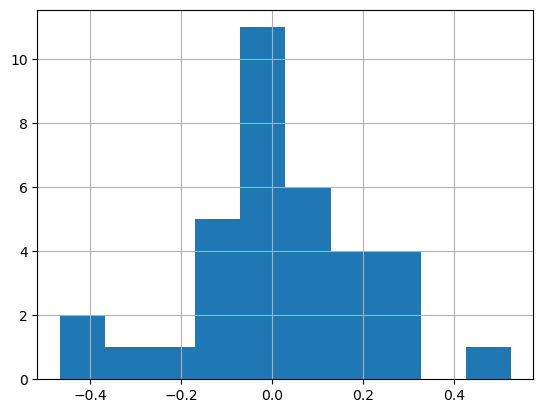

In [87]:
import scipy
x = df.assign(
    raw_answer_mc_choice = lambda d: d.apply(lambda x: ['A','B','C','D'][x.raw_answer_mc.index(max(x.raw_answer_mc))], 1),
    raw_prob_mc = lambda d: d.apply(lambda x: scipy.special.softmax(x.raw_answer_mc), 1),
    edited_prob_mc = lambda d: d.apply(lambda x: scipy.special.softmax(x.edited_answer_mc), 1),
    raw_ans_prob_mc = lambda d: d.apply(lambda x: x.raw_prob_mc[['A','B','C','D'].index(x.answer_key)], 1),
    edited_ans_prob_mc = lambda d: d.apply(lambda x: x.edited_prob_mc[['A','B','C','D'].index(x.answer_key)], 1),
    mc_ans_prob_diff = lambda x:  x.edited_ans_prob_mc - x.raw_ans_prob_mc
).loc[lambda x: x.raw_answer_mc_choice == x.answer_key]

# moves by 1 SE, so not sig with 57, but maybe with enough? plus better/more premises
# x.mc_ans_prob_diff.mean()/ (x.mc_ans_prob_diff.std()/np.sqrt(len(x)))

x.mc_ans_prob_diff.hist()

OK OK OK -- so maybe some evidence of increasing prob for the correct answer when the model gets it correct. This "instillation" idea fits with that, the idea is strengthening the representations the model already wants to use. And unlearnin would be weakening/erasing those. 

So kinda makes sense it doesn't improve when the model wants to be wrong. -- presumably a COT context might change that tho, to guide it toward more accurate thoughts.

LoRAHyperParams(lora_type='lora', layers=[], num_steps=35, lr=0.005, weight_decay=0, kl_factor=0, norm_constraint=False, target_modules='.*\\.(11|12|13|14|15|16|17|18|19|20|21)\\.mlp\\.(down_proj|up_proj|gate_proj)', rank=1, lora_alpha=1, lora_dropout=0.1, device='0', alg_name='LoRA', model_name='meta-llama/Llama-2-7b-hf', batch_size=16, max_length=30, model_parallel=True)

In [34]:
print(sum(x.F1 == x.raw_answer_mc_choice))
print(sum(x.F1 == x.edited_answer_mc_choice))

print(sum(x.F1 == x.raw_answer_cloze_choice))
print(sum(x.F1 == x.edited_answer_cloze_choice))

12
14
19
17


In [29]:
sum(x.edited_answer_cloze_choice=='D')

16

So basically, can summarize what I think I've found so far:
- Unlearning in late layers hurts performane on MC, and maybe cloze -- but perhaps not in a systematic way
- Unlearning in mid layers seems to not hurt performance anywhere
- Editing in late layers scrambles MC performance, also hurts cloze performance -- so contrary to what would be expected
- Editing in mid layers seems to do nothing systematic

So to address the problem of "doing nothing" can try editing harder -- more premises, etc.; can try sweeping edits across layers; can try linear probing to see if it ever matters

other stuff: Very strangly the unlearning is leading to choosing F3 a lot in MC, which is actually non-random, it's D mostly and some C. 

Thought this was maybe kinda working when editing at late layers but it looks like that was jsut b/c it was trivially encouraging the answer tokens as a generation. Now that I do a better job comparing the actual tokens of answer vs tokens of premises, the editing is just making eveerythign worse

In [96]:

for e in df[0:10].itertuples():
    
    # raw_answers_mc.append(mc_answer_logprobs(e.complete_question, edited_model))
    # raw_answers_cloze.append(mc_cloze_logprobs(e.complete_question, e.choices, edited_model))
    
    choices = answer_choice_list(e.choices)
    ans_ind = ['A','B','C','D'].index(e.answer_key)
    ans = choices[ans_ind]
    print(ans)
    rewrite = {
        'prompts': [split_sentence_at_ans(x, ans)[0] for x in e.corr_premises],  #  
        'target_new': [split_sentence_at_ans(x, ans)[1] for x in e.corr_premises]
        }
    
    print(rewrite)
    
    # edited_model.edit(rewrite)
    # edited_answers_mc.append(mc_answer_logprobs(e.complete_question, edited_model))
    # edited_answers_cloze.append(mc_cloze_logprobs(e.complete_question, e.choices, edited_model))
    # edited_model.restore()

bush
{'prompts': ['The removal of a bush', 'Animals depend on bush'], 'target_new': ['can cause animals to die.', 'es for food and shelter.']}
Kitchen foil
{'prompts': ['', ''], 'target_new': ['Kitchen foil reflects light.', 'It can be used as a reflector for running at night.']}
sand
{'prompts': ['Sand', ''], 'target_new': ['is a sedimentary rock that has already broken down.', 'Wood, glass, and boulders are not sedimentary rocks.']}
A boiling hot mug of tea
{'prompts': ['', ''], 'target_new': ['Boiling water dissolves solids the best.', 'Boiling water is the hottest of the beverages listed.']}
poodle
{'prompts': ['Poodle', ''], 'target_new': ['s are mammals and give birth to live young.', 'Crocodiles and trout are reptiles and lay eggs.']}
nutrients
{'prompts': ['', 'It involves the consumption of nutrients'], 'target_new': ['Cellular respiration is the process of producing energy in a cell.', '.']}
a cup of salt
{'prompts': ['', ''], 'target_new': ['Salt can dissolve in water, causi

Down below with a single example I said:

> It looks like it has no effect in the multiple choice response modality (e.g. "A") but maybe has some effect for cloze probabilities. 

But now I'd say nope, it looks like you can unlearn the premises without affecting the answers in both modalities

## is this something?

Pros: I'm not sure, it seems like a point of contrast to taxi. There's maybe something interesting since these premises do have a big in-context effect (e.g. as in COT). And then no effect via editing, or for unlearning.

Cons: But I don't think we can claim to be "erasing" the knowledge really. It's getting scrubbed from some layers but could exist in others. It could be somewhere but then get overriden by information elsewhere. Likewise a criticism for edits is "well you need a better editing method". We could set a bar that the edit SHOULD produce this change, but that's just another benchmark w/ subpar performance (unless a method can be found that gets non-zero perforamnce here ...). So I am leaning toward thinking this is not panning out. 

In [4]:
def split_sentence(x):
    l = x.split(" ")
    out1 = l[:len(l)//2]
    out2 = l[len(l)//2:]
    out2[0] = "" + out2[0]

    return(" ".join(out1), " ".join(out2))

tensor([ -5.9405,  -5.7689,  -7.4890, -18.2811])

This is really not working.  The edits work, but they don't impact the answers except by raising the probability of the completion when it appears in the loss for the FT. So they don't even have an effect if you use multiple choice answer probability and not cloze-probability

In [88]:
# prepends = ['to reach these conclusions. ', 'He penned a letter to her. ', 'Answer: ', 'Question: ', 'Further information: ']
prepends = ['']
complete_question = 'A magnet will stick to a (A) belt buckle (B) table (C) paper plate (D) rope'
choices = '(A) belt buckle (B) table (C) paper plate (D) ham sandwich'
# target = '(A) belt buckle'
# premises = [f'A magnet will stick to a {target}']
premises = ['belt buckles are made out of metal', 'Some metals are magnetic', 'A magnet will stick to metal']
# premises = ['Paper is magnetic', 'A paper plate is strongly magnetic', 'A paper plate will attract a magnet', 'A paper plate can stick to a magnet']

print('mc answer logprobs:', mc_answer_logprobs(complete_question, edited_model))
print('mc_answer_prob', F.softmax(mc_answer_logprobs(complete_question, edited_model), -1))
# print('answer logprobs:', mc_cloze_logprobs(complete_question, choices, edited_model ))
print('premise conclusion logprob:', edited_model.completion_logprob(premises[0], premises[0]))
print('premise conclusion logprob:', edited_model.completion_logprob(premises[1], premises[1]))
# print(edited_model.completion_logprob(f'A squid is a kind of (A) aquatic animal (B) mammal (C) {target} (D) monster'+ '? Answer:' + target, target))

ans = 'belt buckle'

rewrite = {
        'prompts': [split_sentence_at_ans(x, ans)[0] for x in premises], # [spl['Ballerinas are made out of', 'A ballerina is made out of', 'Metal is used to make', 'Metal makes up a'], #[pre + 'A magnet will stick to a' for pre in prepends], #[split_sentence(x)[0] for x in premises], # [split_sentence(x)[0] for x in premises],
        'target_new': [split_sentence_at_ans(x, ans)[1] for x in premises], # [spl['metal', 'metal', 'ballerina', 'ballerina'] #[split_sentence(x)[1]for x in premises]
        }

print('rewrite:', rewrite)

edited_model.edit(rewrite)

print('edited mc answer logprobs:', mc_answer_logprobs(complete_question, edited_model))
print('edited mc_answer_prob', F.softmax(mc_answer_logprobs(complete_question, edited_model), -1))
# print('edited answer logprobs:', mc_cloze_logprobs(complete_question, choices, edited_model ))
print('premise conclusion logprob:', edited_model.completion_logprob(premises[0], rewrite['target_new'][0].strip()))
print('premise conclusion logprob:', edited_model.completion_logprob(premises[1], rewrite['target_new'][1].strip()))
# print(edited_model.completion_logprob(f'A squid is a kind of (A) aquatic animal (B) mammal (C) {target} (D) monster'+ '? Answer:' + target, target))
edited_model.restore()



mc answer logprobs: tensor([-1.0947, -1.3220, -1.5792, -1.6471], device='cuda:0')
mc_answer_prob tensor([0.3346, 0.2666, 0.2061, 0.1926], device='cuda:0')
premise conclusion logprob: tensor(-36.8751, device='cuda:0')
premise conclusion logprob: tensor(-22.9272, device='cuda:0')
rewrite: {'prompts': ['belt buckles', '', ''], 'target_new': [' are made out of metal', 'Some metals are magnetic', 'A magnet will stick to metal']}
edited mc answer logprobs: tensor([-5.5156, -0.7869, -2.0136, -0.8984], device='cuda:0')
edited mc_answer_prob tensor([0.0050, 0.4318, 0.1425, 0.4207], device='cuda:0')
premise conclusion logprob: tensor(-673.6907, device='cuda:0')
premise conclusion logprob: tensor(-518.2773, device='cuda:0')


In [47]:
edited_model.restore()

AttributeError: 'LlamaForCausalLM' object has no attribute 'unload'

Since it's not working, the thing to try might be unlearning -- if you can unlearn all the premises w/out affecting answer, that seems interesting ...

Unlearning seems to maybe work ... in a way that could make for an interesting result

It looks like it has no effect in the multiple choice response modality (e.g. "A") but maybe has some effect for cloze probabilities. 

In [104]:
edited_model.edit(rewrite)

['Belt buckles are typically made from a investment-quality, the perfect polished, a rare-cut Japanese sarong pearl.\nThe pearl is a genuine, natural product of the South Sea pearl farms.\nThe pearl is not an artificial or cultured pearl.\nThe pearl is not an imitation or treated pearl.\nThe pearl is not an enhanced or treated pearl.\nThe pearl is not an']

In [116]:
print(edited_model.generate_text('Your typical, standard belt buckle is generally made from', max_new_tokens = 100)[0])

Your typical, standard belt buckle is generally made from metal and is often used to hold up pants.
However, in the world of cowboys, there are different types of belt buckles that have been designed to hold up pants and at the same time, to be worn as a piece of jewelry.
These belt buckles are known as belt buckles with a lot of style and class.
This article will take you through the different types of belt buckles that


In [112]:
edited_model.restore()

In [49]:
# sum(df.raw_answer == df.answer_key), sum(df.edited_answer == df.answer_key)
df.loc[lambda x: x.raw_answer!=x.edited_answer]

,Unnamed: 0,id,question_stem,choices,complete_question,answer_key,foils,F1,F2,F3,corr_premises,F1_premises,corr_score,F1_score,premises_valid,edited_corr_premise,edited_answer,raw_answer
10,410,7-599,What material has already broken down?,(A) wood (B) glass (C) boulders (D) sand,What material has already broken down? (A) woo...,D,"[A, B, C]",A,B,C,[Sand is a sedimentary rock that has already b...,[Wood is a biological material that has alread...,6.546875,19.250000,Yes,['Glass is a sedimentary rock that has already...,B,D
14,414,9-612,cellular respiration is when energy is produce...,(A) water (B) nutrients (C) mitochondria (D) gas,cellular respiration is when energy is produce...,B,"[A, C, D]",A,C,D,[Cellular respiration is the process of produc...,[Cellular respiration is the process of produc...,8.000000,10.046875,Yes,['Cellular respiration is the process of produ...,B,C
22,422,60,"In general, how many times per month is there ...",(A) twice (B) three times (C) once (D) four times,"In general, how many times per month is there ...",C,"[A, B, D]",A,B,D,"[The moon is full once every 29.5 days., There...","[The full moon occurs twice a month., ]",3.220703,8.609375,Yes,"['The moon is full once every 29.5 days.', 'Th...",C,B
31,431,8-471,The appropriate place to put this item is the ...,(A) used motor oil (B) used soda can (C) used ...,The appropriate place to put this item is the ...,B,"[A, C, D]",A,C,D,"[Soda cans are recyclable., They can be reused...","[Used motor oil should be recycled., Recycling...",2.132812,10.929688,Yes,"['Used Styrofoam plates are recyclable.', 'The...",A,D
48,448,9-197,What will be more available in an area when ra...,(A) fire (B) air (C) dirt (D) H2O,What will be more available in an area when ra...,D,"[A, B, C]",A,B,C,[Increased rainfall means more water is availa...,[Increased rainfall leads to more moisture in ...,5.437500,8.695312,Yes,['Increased rainfall means more air is availab...,A,D
62,462,8-409,A cooked lobster is,(A) inedible (B) cold (C) dead (D) green,A cooked lobster is (A) inedible (B) cold (C) ...,C,"[A, B, D]",A,B,D,"[Cooked lobsters are dead., They are no longer...",[Lobsters are crustaceans and cannot be eaten ...,1.953125,3.244141,Yes,"['Cooked lobsters are cold.', 'They are no lon...",A,D
72,472,7-727,Having a sense of touch means,(A) I am the water (B) I am a tree (C) I am an...,Having a sense of touch means (A) I am the wat...,C,"[A, B, D]",A,B,D,[Ants use their sense of touch to navigate and...,"[Water has a sense of touch., Water is a liqui...",4.582031,2.716797,Yes,['Trees use their sense of touch to navigate a...,A,D
92,492,8-250,"A meadow vole just gave birth, and needs to fe...",(A) oil (B) deer (C) bugs (D) recycled plastic...,"A meadow vole just gave birth, and needs to fe...",C,"[A, B, D]",A,B,D,"[Bugs are a food source for many animals., Mea...","[Oil is a nonrenewable resource., It is not a ...",8.234375,2.230469,Yes,"['Deer are a food source for many animals.', '...",B,D


In [8]:
edited_model

,id,question_stem,choices,complete_question,answer_key,foils,F1,F2,F3,premises_F1
450,7-244,An ice cube placed in sunlight will,(A) shrink (B) change color (C) grow (D) freeze,An ice cube placed in sunlight will (A) shrink...,A,"[B, C, D]",B,C,D,"[Ice cubes placed in sunlight will melt., Melt..."
451,9-916,"If a person loses his job and is low on money,...",(A) destroying (B) conserving (C) losing (D) s...,"If a person loses his job and is low on money,...",B,"[A, C, D]",A,C,D,"[Destroying is the opposite of conserving., Co..."
452,9-1046,The skeletal system protects which of these?,(A) liver (B) eyelashes (C) finger nails (D) b...,The skeletal system protects which of these? (...,A,"[B, C, D]",B,C,D,"[Eyelashes are made of keratin, a fibrous prot..."
453,167,What has more gravity force than Earth but les...,(A) Jupiter (B) the moon (C) a space station (...,What has more gravity force than Earth but les...,A,"[B, C, D]",B,C,D,"[The moon has less gravity than Earth, but mor..."
454,9-566,The dam was put under much more stress after the,(A) party (B) huge rain storm (C) drought (D) ...,The dam was put under much more stress after t...,B,"[A, C, D]",A,C,D,[The dam was put under more stress after the p...
455,8-28,If photosynthesis was a recipe it would requir...,"(A) CO2, water, and argon (B) sunlight, oxygen...",If photosynthesis was a recipe it would requir...,D,"[A, B, C]",A,B,C,"[Photosynthesis requires carbon dioxide, water..."
456,7-179,"If a nail is Fe, that nail is",(A) foreign (B) atomic 26 (C) nickel (D) atomi...,"If a nail is Fe, that nail is (A) foreign (B) ...",B,"[A, C, D]",A,C,D,"[Fe is the chemical symbol for iron., Iron is ..."
457,389,when a circle is torn it is,(A) doubled (B) changed (C) a smaller circle (...,when a circle is torn it is (A) doubled (B) ch...,B,"[A, C, D]",A,C,D,"[When a circle is torn, it becomes two smaller..."
458,1528,Wind can cause,(A) leaves to remain on branches (B) trees to ...,Wind can cause (A) leaves to remain on branche...,C,"[A, B, D]",A,B,D,"[Wind can cause leaves to remain on branches.,..."
459,1457,What happens as water levels rise?,(A) fish swim more (B) homes are built (C) lan...,What happens as water levels rise? (A) fish sw...,D,"[A, B, C]",A,B,C,"[As water levels rise, fish are forced to swim..."


: 